In [1]:
%load_ext autoreload
%autoreload 2

# Analysis of hyperparameter search v3
The purpose of this notebook is to identify CT-RNNs with a high cumulative variance explained.

## Imports

In [2]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import jax.numpy as jnp
from jax import random
from flax import linen as nn
from modularRNN.model import CTRNNCell
from modularRNN.task import ModularArithmeticTask
from modularRNN.training import create_train_state, ModelParameters

from functools import partial

2024-04-09 18:16:05.500647: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-09 18:16:06.255799: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-04-09 18:16:06.255855: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-04-09 18:16:06.255861: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed proper

## Analysis

In [3]:
job_folder = "../../data/hyperparameter_3"
search_results = []

for task_id in range(384):
    try:
        metrics_loc = os.path.join(job_folder, f"task_{task_id}/metrics_history.csv")
        test_loss_min = pd.read_csv(metrics_loc)['test_loss'].min()
        test_acc_max = pd.read_csv(metrics_loc)['test_accuracy'].max()
        long_loss_min = pd.read_csv(metrics_loc)['long_loss'].min()
        long_acc_max = pd.read_csv(metrics_loc)['long_accuracy'].max()

        var_explained_loc = os.path.join(job_folder, f"task_{task_id}/cumulative_variance.npy")
        var_exp_arr = jnp.load(var_explained_loc)
        
        params_loc = os.path.join(job_folder, f"task_{task_id}/params.json")
        with open(params_loc, 'r') as f:
            json_params = json.load(f)
        
        seed = json_params.get('seed', 0)
        alpha = json_params.get('alpha', 0.1)
        noise = json_params.get('noise', 0.05)
        pulse_mean = json_params.get('pulse_mean', 8)
        mod_set = json_params.get('mod_set', [5,])
        mod_value_list = len(mod_set)
        training_trials = json_params.get('training_trials', 3200)
        train_batch_size = json_params.get('train_batch_size', 128)
        testing_trials = json_params.get('testing_trials', 320)
        lr = json_params.get('lr', 0.001)
        epochs = json_params.get('epochs', 500)
        weight_decay = json_params.get('weight_decay', 0.0001)
        l2_penalty = json_params.get('l2_penalty', 0.0001)

        task_stats_params = {
            'test_loss_min': test_loss_min,
            'test_acc_max': test_acc_max,
            'long_loss_min': long_loss_min,
            'long_acc_max': long_acc_max,
            'cum_var': var_exp_arr[2].item(),
            'seed': seed,
            'alpha': alpha,
            'noise': noise,
            'pulse_mean': pulse_mean,
            'mod_set': mod_set,
            'mod_value_list': mod_value_list,
            'training_trials': training_trials,
            'train_batch_size': train_batch_size,
            'testing_trials': testing_trials,
            'lr': lr,
            'epochs': epochs,
            'weight_decay': weight_decay,
            'l2_penalty': l2_penalty,
        }
        search_results.append(task_stats_params)

    except FileNotFoundError:
        continue

In [4]:
df_search_results = pd.DataFrame(search_results)
df_search_results.sort_values('cum_var', ascending=False).head(25)

,test_loss_min,test_acc_max,long_loss_min,long_acc_max,cum_var,seed,alpha,noise,pulse_mean,mod_set,mod_value_list,training_trials,train_batch_size,testing_trials,lr,epochs,weight_decay,l2_penalty
261,0.000712,1.000000,0.000279,1.000000,0.869014,261,0.1,0.05,12,"[4, 3]",2,3200,128,640,0.010,2500,0.001,0.010
119,0.000745,1.000000,0.000295,1.000000,0.862672,119,0.1,0.05,12,"[3, 4]",2,3200,128,640,0.010,2000,0.001,0.010
143,0.000743,1.000000,0.000295,1.000000,0.860315,143,0.1,0.05,12,"[4, 3]",2,3200,128,640,0.010,2000,0.001,0.010
184,0.000752,1.000000,0.000303,1.000000,0.859834,184,0.1,0.05,12,"[4, 3]",2,3200,128,640,0.010,2500,0.001,0.010
160,0.000762,1.000000,0.000309,1.000000,0.857662,160,0.1,0.05,12,"[4, 3]",2,3200,128,640,0.010,2000,0.001,0.010
72,0.000759,1.000000,0.000309,1.000000,0.857106,72,0.1,0.05,12,"[3, 4]",2,3200,128,640,0.005,2500,0.001,0.010
227,0.000788,1.000000,0.000327,1.000000,0.854004,227,0.1,0.05,12,"[3, 4]",2,3200,128,640,0.005,2000,0.001,0.010
182,0.000771,1.000000,0.000316,1.000000,0.850591,182,0.1,0.05,12,"[3, 4]",2,3200,128,640,0.010,1500,0.001,0.010
31,0.000794,1.000000,0.000326,1.000000,0.849233,31,0.1,0.05,12,"[4, 3]",2,3200,128,640,0.005,2000,0.001,0.010
65,0.000863,1.000000,0.000374,1.000000,0.838120,65,0.1,0.05,12,"[4, 3]",2,3200,128,640,0.005,2000,0.001,0.010


## Analyze seed 261

In [5]:
task_id = 'task_261'

params_for_json = f"../../data/hyperparameter_2/{task_id}/params.json"
example_csv = f"../../data/hyperparameter_2/{task_id}/metrics_history.csv"
model_params_save = f"../../data/hyperparameter_2/{task_id}/test_params.bin"

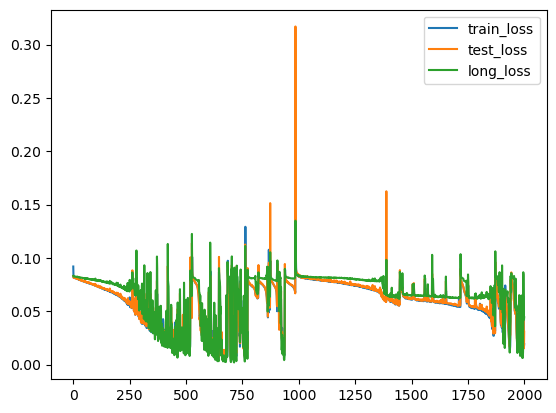

In [6]:
df_metrics = pd.read_csv(example_csv)

plt.plot(df_metrics['train_loss'], label='train_loss')
plt.plot(df_metrics['test_loss'], label='test_loss')
plt.plot(df_metrics['long_loss'], label='long_loss')
plt.legend()
plt.show()